<a href="https://colab.research.google.com/github/kxtubh/LungCancerPrediction/blob/main/resnet_lungcancer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#1. Import all dependencies and dataset

In [1]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))


Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 67 bytes


In [2]:
!pip install -q kaggle

In [3]:
!mkdir ~/.kaggle


In [4]:
!mv kaggle.json ~/.kaggle/

In [5]:
!chmod 600 ~/.kaggle/kaggle.json # Sets proper file permissions

In [6]:
!kaggle datasets download -d adityamahimkar/iqothnccd-lung-cancer-dataset

Dataset URL: https://www.kaggle.com/datasets/adityamahimkar/iqothnccd-lung-cancer-dataset
License(s): copyright-authors


In [7]:


import tensorflow as tf
from zipfile import ZipFile
import os,glob
import cv2
from tqdm._tqdm_notebook import tqdm_notebook as tqdm
import numpy as np
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Convolution2D, Dropout, Dense,MaxPooling2D
from keras.layers import BatchNormalization
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from zipfile import ZipFile
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model


<ipython-input-7-9c4e654c9cb9>:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.*` instead of `tqdm._tqdm_notebook.*`
  from tqdm._tqdm_notebook import tqdm_notebook as tqdm


#2. Image preprocessing

In [8]:

file_name = "/content/iqothnccd-lung-cancer-dataset.zip"
with ZipFile(file_name,'r') as zip:
  zip.extractall()
  print('Done')



Done


In [9]:
 os.chdir('/content/The IQ-OTHNCCD lung cancer dataset/The IQ-OTHNCCD lung cancer dataset/Bengin cases')
images = []
labels = []

for i in tqdm(os.listdir()):
      img = cv2.imread(i)
      img = cv2.resize(img,(224,224))
      images.append(img)
      labels.append((i[0:1]))


  0%|          | 0/120 [00:00<?, ?it/s]

In [10]:
os.chdir('/content/The IQ-OTHNCCD lung cancer dataset/The IQ-OTHNCCD lung cancer dataset/Malignant cases')
for i in tqdm(os.listdir()):
      img = cv2.imread(i)
      img = cv2.resize(img,(224,224))
      images.append(img)
      labels.append((i[0:1]))

  0%|          | 0/561 [00:00<?, ?it/s]

In [11]:
os.chdir('/content/The IQ-OTHNCCD lung cancer dataset/The IQ-OTHNCCD lung cancer dataset/Normal cases')
for i in tqdm(os.listdir()):
      img = cv2.imread(i)
      img = cv2.resize(img,(224,224))
      images.append(img)
      labels.append((i[0:1]))

  0%|          | 0/416 [00:00<?, ?it/s]

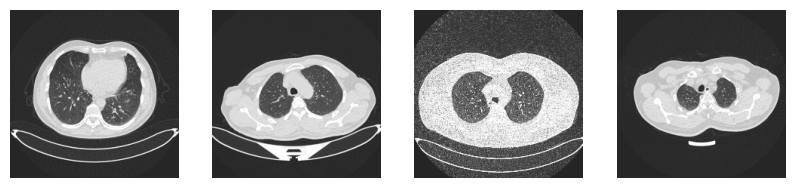

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
for i in range(4):
    plt.subplot(1, 4, i+1)
    plt.imshow(images[i], cmap="gray")
    plt.axis('off')
plt.show()

#3.Spliting the dataset

In [13]:
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.33, random_state=42)
print ("Shape of an image in X_train: ", X_train[0].shape)
print ("Shape of an image in X_test: ", X_test[0].shape)

Shape of an image in X_train:  (224, 224, 3)
Shape of an image in X_test:  (224, 224, 3)


In [14]:
le = preprocessing.LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.fit_transform(y_test)

In [15]:
y_train = tf.keras.utils.to_categorical(y_train, num_classes=3)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=3)
y_train = np.array(y_train)
X_train = np.array(X_train)
y_test = np.array(y_test)
X_test = np.array(X_test)
print("X_train Shape: ", X_train.shape)
print("X_test Shape: ", X_test.shape)
print("y_train Shape: ", y_train.shape)
print("y_test Shape: ", y_test.shape)


X_train Shape:  (734, 224, 224, 3)
X_test Shape:  (363, 224, 224, 3)
y_train Shape:  (734, 3)
y_test Shape:  (363, 3)


#4. using the pretrained model

In [16]:

# Create the base ResNet50 model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Add custom classification layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(3, activation='softmax')(x)  # 3 output classes

# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


In [17]:
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])



In [18]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 56, 56, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 56, 56, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 25,688,963 (98.00 MB)

 Trainable params: 2,101,251 (8.02 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

#5. Model Training

In [19]:
# Train the model
history=model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test)) # Adjust epochs and batch size as needed



Epoch 1/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 29s 674ms/step - accuracy: 0.5947 - loss: 2.9653 - val_accuracy: 0.8237 - val_loss: 1.0633
Epoch 2/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 22s 139ms/step - accuracy: 0.8697 - loss: 0.4928 - val_accuracy: 0.8567 - val_loss: 0.3174
Epoch 3/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 139ms/step - accuracy: 0.8819 - loss: 0.2841 - val_accuracy: 0.8623 - val_loss: 0.2954
Epoch 4/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 5s 124ms/step - accuracy: 0.9235 - loss: 0.1616 - val_accuracy: 0.8843 - val_loss: 0.2596
Epoch 5/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 5s 141ms/step - accuracy: 0.9608 - loss: 0.1258 - val_accuracy: 0.9036 - val_loss: 0.2241
Epoch 6/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 0.9755 - loss: 0.1009 - val_accuracy: 0.8871 - val_loss: 0.2255
Epoch 7/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 126ms/step - accuracy: 0.9781 - loss: 0.0974 - val_accuracy: 0.8953 - val_loss: 0.2473
Epoch 8/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - accuracy: 0.9639 - loss: 0.1048 - val_accuracy: 

#6. Evaluation and Predictions


In [20]:
# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")


12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - accuracy: 0.8937 - loss: 0.2606
Test Loss: 0.2494
Test Accuracy: 0.8981


In [21]:
def calculate_class_precision():
    """
    Calculate precision for each class based on predictions on the test set.
    Returns a dictionary with class indices as keys and precision values as values.
    """
    # Make predictions on the test set
    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true_classes = np.argmax(y_test, axis=1)

    # Calculate precision for each class
    class_precision = {}
    for class_idx in range(3):  # Assuming 3 classes: Benign, Malignant, Normal
        # Find all predictions for this class
        class_predictions = (y_pred_classes == class_idx)
        if np.sum(class_predictions) > 0:
            # True positives / (True positives + False positives)
            true_positives = np.sum((y_true_classes == class_idx) & class_predictions)
            precision = true_positives / np.sum(class_predictions)
            class_precision[class_idx] = precision
        else:
            class_precision[class_idx] = 0.0

    return class_precision

In [22]:
def predict_image_class(image_path, show_plot=True):
    """
    Predict the class of an image with confidence and precision metrics.
    Also displays the input image and bar plots for confidence and precision.

    Args:
        image_path: Path to the image file
        show_plot: Whether to display the visualization (default: True)

    Returns:
        dict: A dictionary containing the predicted class, confidence, and precision
    """
    try:
        # Calculate class precision if not already calculated
        if not hasattr(predict_image_class, "class_precision"):
            predict_image_class.class_precision = calculate_class_precision()

        # Class names mapping - hardcoded based on the dataset structure
        class_names = {0: "Benign", 1: "Malignant", 2: "Normal"}

        # Load and preprocess the image
        img = cv2.imread(image_path)
        if img is None:
            return {"error": "Could not load image."}

        # Store original image for display
        display_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB for display

        # Resize for prediction
        img_resized = cv2.resize(img, (224, 224))
        img_batch = np.expand_dims(img_resized, axis=0)

        # Make the prediction
        prediction = model.predict(img_batch)

        # Get the predicted class index and confidence
        predicted_class_index = np.argmax(prediction[0])
        confidence = float(prediction[0][predicted_class_index])

        # Get the precision for this class
        precision = float(predict_image_class.class_precision.get(predicted_class_index, 0.0))

        # Create result dictionary
        result = {
            "predicted_class": class_names.get(predicted_class_index, f"Unknown ({predicted_class_index})"),
            "confidence": round(confidence * 100, 2),  # Convert to percentage
            "precision": round(precision * 100, 2),    # Convert to percentage
            "raw_probabilities": {}
        }

        # Add raw probabilities with proper integer indexing
        for i, prob in enumerate(prediction[0]):
            result["raw_probabilities"][int(i)] = round(float(prob) * 100, 2)

        # Create visualization if show_plot is True
        if show_plot:
            # Setup the plot
            fig = plt.figure(figsize=(15, 6))

            # Plot 1: Input Image
            ax1 = fig.add_subplot(1, 2, 1)
            ax1.imshow(display_img)
            ax1.set_title("Input Image")
            ax1.axis('off')

            # Plot 2: Confidence and Precision Bar Chart
            ax2 = fig.add_subplot(1, 2, 2)

            # Prepare data for bar chart
            classes = list(class_names.values())
            confidence_values = [result["raw_probabilities"].get(i, 0) for i in range(3)]
            precision_values = [round(predict_image_class.class_precision.get(i, 0) * 100, 2) for i in range(3)]

            # Set bar positions
            bar_width = 0.35
            x = np.arange(len(classes))

            # Create bars
            bars1 = ax2.bar(x - bar_width/2, confidence_values, bar_width, label='Confidence (%)', color='skyblue')
            bars2 = ax2.bar(x + bar_width/2, precision_values, bar_width, label='Precision (%)', color='orange')

            # Add labels and title
            ax2.set_xlabel('Classes')
            ax2.set_ylabel('Percentage (%)')
            ax2.set_title('Confidence vs Precision')
            ax2.set_xticks(x)
            ax2.set_xticklabels(classes)
            ax2.legend()

            # Add value labels on top of bars
            def add_labels(bars):
                for bar in bars:
                    height = bar.get_height()
                    ax2.annotate(f'{height}%',
                                xy=(bar.get_x() + bar.get_width() / 2, height),
                                xytext=(0, 3),  # 3 points vertical offset
                                textcoords="offset points",
                                ha='center', va='bottom')

            add_labels(bars1)
            add_labels(bars2)

            # Highlight the predicted class
            predicted_idx = list(class_names.values()).index(result["predicted_class"])
            bars1[predicted_idx].set_color('blue')
            bars2[predicted_idx].set_color('darkred')

            # Add a prediction summary text box
            summary_text = f"Prediction: {result['predicted_class']}\n" \
                           f"Confidence: {result['confidence']}%\n" \
                           f"Precision: {result['precision']}%"

            plt.figtext(0.5, 0.01, summary_text, ha='center', fontsize=12,
                        bbox={"facecolor":"lightgray", "alpha":0.5, "pad":5})

            plt.tight_layout()
            plt.subplots_adjust(bottom=0.15)  # Make space for the summary text
            plt.show()

        return result

    except Exception as e:
        import traceback
        traceback.print_exc()
        return {"error": f"Error during prediction: {str(e)}"}

12/12 ━━━━━━━━━━━━━━━━━━━━ 8s 419ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


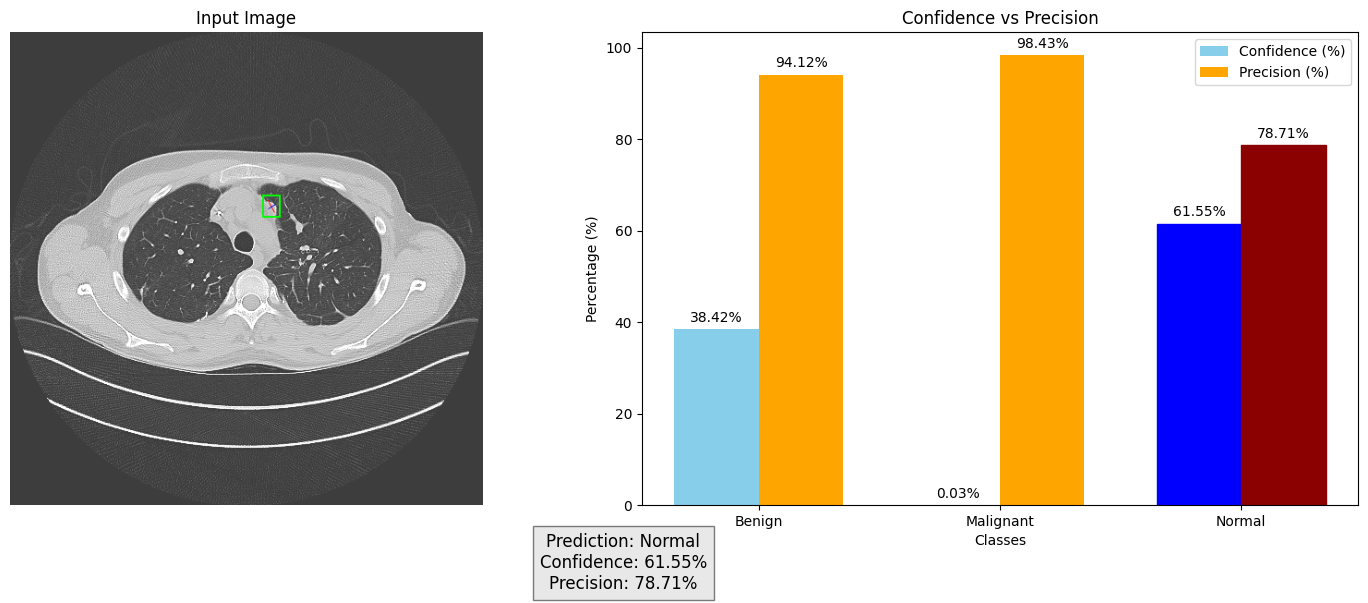

Predicted class: Normal
Confidence: 61.55%
Precision: 78.71%


In [23]:
test_image = "/content/Test cases/000103_03_01_082.png"
result = predict_image_class(test_image)

# The function will automatically display the visualization
# You can also access the detailed metrics from the result dictionary
print(f"Predicted class: {result['predicted_class']}")
print(f"Confidence: {result['confidence']}%")
print(f"Precision: {result['precision']}%")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


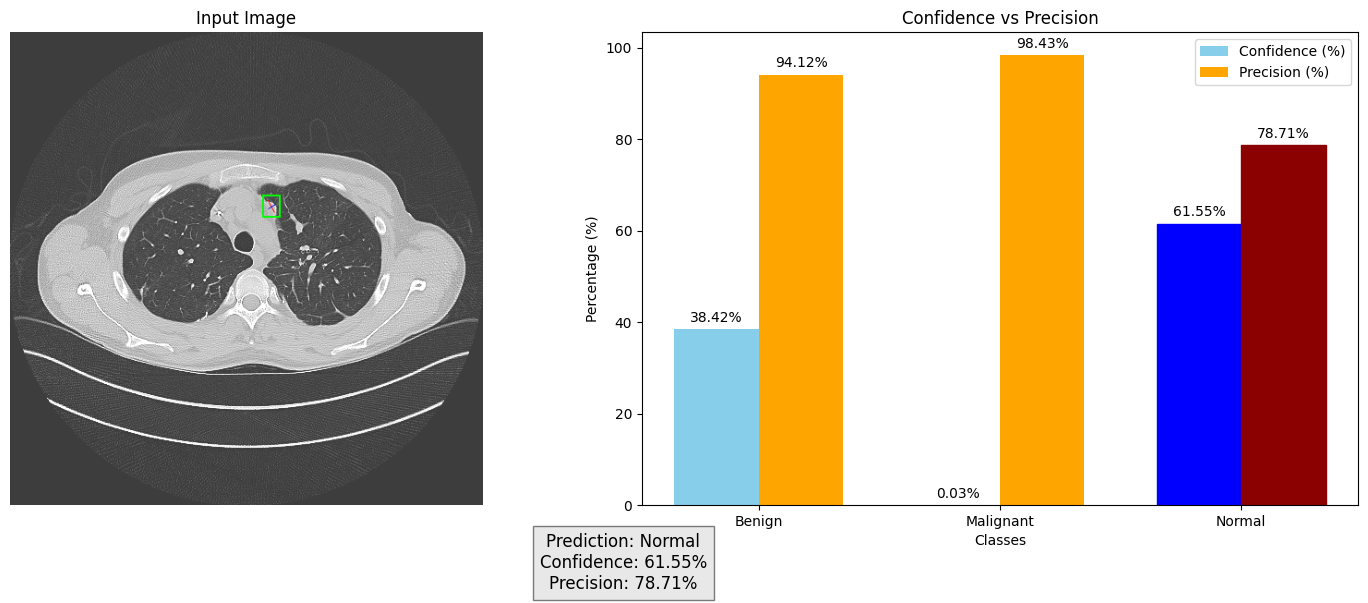

Predicted class: Normal
Confidence: 61.55%
Precision: 78.71%
Class probabilities:
  Benign: 38.42%
  Malignant: 0.03%
  Normal: 61.55%


In [24]:
# Example usage
test_image = "/content/Test cases/000103_03_01_082.png"
result = predict_image_class(test_image)
print(f"Predicted class: {result['predicted_class']}")
print(f"Confidence: {result['confidence']}%")
print(f"Precision: {result['precision']}%")
print("Class probabilities:")
for class_idx, prob in result['raw_probabilities'].items():
     class_name = {0: "Benign", 1: "Malignant", 2: "Normal"}.get(class_idx, f"Class {class_idx}")
     print(f"  {class_name}: {prob}%")

#7. Visualize

In [25]:
# ============================================
# 1. Plot Training and Validation Loss Curves
# ============================================
def plot_loss_curves(history):
    """
    Plot the training and validation loss curves.

    Args:
        history: Keras training history object
    """
    plt.figure(figsize=(12, 5))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss Curves')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy Curves')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()


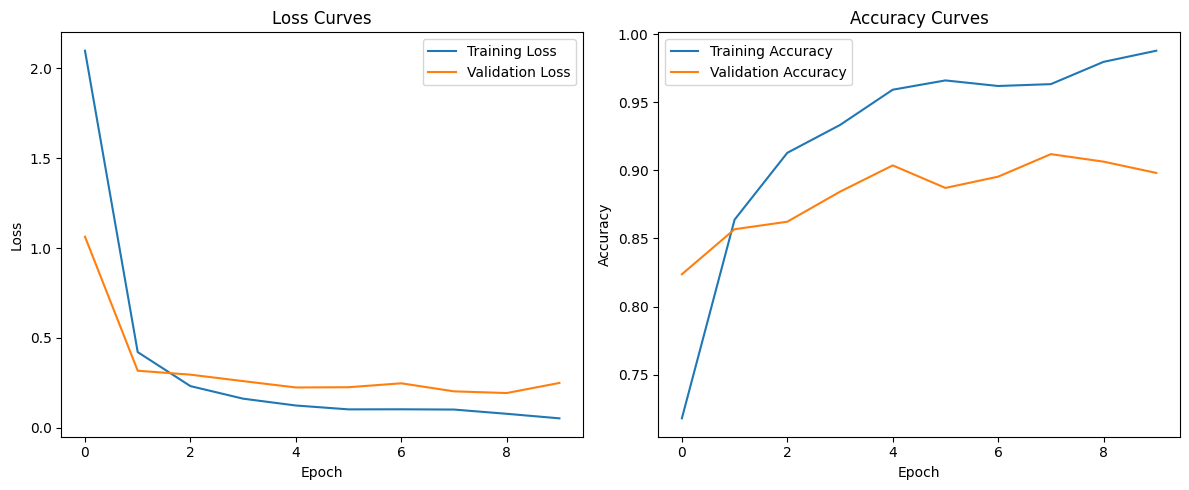

In [26]:
plot_loss_curves(history)

In [37]:
from sklearn.metrics import roc_curve, auc
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle
import time

def plot_roc_curve(sample_size=None):
    """
    Plot the ROC curve for multi-class classification.

    Args:
        sample_size: Optional int to subsample the test set for faster computation
    """
    print("Starting ROC curve calculation...")
    start_time = time.time()

    # Get predictions on test set (with optional sampling)
    if sample_size and sample_size < len(X_test):
        # Use a smaller random subset for faster computation
        indices = np.random.choice(len(X_test), sample_size, replace=False)
        X_test_sample = X_test[indices]
        y_test_sample = y_test[indices]
        print(f"Using {sample_size} random samples from test set...")
        y_pred_proba = model.predict(X_test_sample, verbose=0)
        y_test_onehot = y_test_sample
    else:
        # Use the full test set
        print("Using full test set...")
        y_pred_proba = model.predict(X_test, verbose=0)
        y_test_onehot = y_test

    print(f"Prediction time: {time.time() - start_time:.2f} seconds")

    # Calculate ROC curve and ROC area for each class
    n_classes = 3
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    # Calculate per-class ROC curves
    calc_start = time.time()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_onehot[:, i], y_pred_proba[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    print(f"Per-class ROC calculation: {time.time() - calc_start:.2f} seconds")

    # Compute micro-average ROC curve and ROC area
    micro_start = time.time()
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test_onehot.ravel(), y_pred_proba.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    print(f"Micro-average calculation: {time.time() - micro_start:.2f} seconds")

    # Create the plot
    plt.figure(figsize=(10, 8))

    # Plot micro-average ROC curves
    plt.plot(fpr["micro"], tpr["micro"],
             label=f'Micro-average ROC (AUC = {roc_auc["micro"]:.2f})',
             color='deeppink', linestyle=':', linewidth=4)

    # Skip the macro average calculation which is very computationally expensive
    # and plot individual class ROC curves instead

    # Plot ROC curves for all classes
    colors = ['aqua', 'darkorange', 'cornflowerblue']
    class_names = {0: "Benign", 1: "Malignant", 2: "Normal"}

    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i], color=colors[i], lw=2,
                 label=f'ROC curve of class {class_names[i]} (AUC = {roc_auc[i]:.2f})')

    # Add diagonal line (random classifier)
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Multi-class ROC Curves')
    plt.legend(loc="lower right")
    plt.grid(alpha=0.3)

    print(f"Total execution time: {time.time() - start_time:.2f} seconds")
    plt.show()

Starting ROC curve calculation...
Using full test set...
Prediction time: 1.56 seconds
Per-class ROC calculation: 0.01 seconds
Micro-average calculation: 0.00 seconds
Total execution time: 1.59 seconds


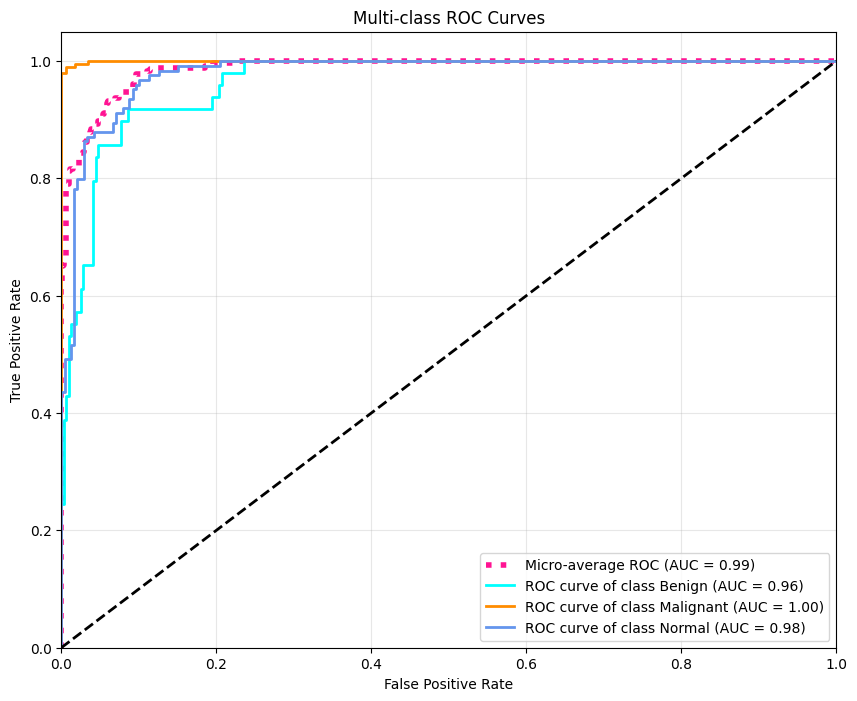

In [39]:
plot_roc_curve()

In [28]:

# ============================================
# 3. Plot Confusion Matrix
# ============================================
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def plot_confusion_matrix():
    """
    Plot the confusion matrix for model predictions.
    """
    # Make predictions on test set
    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true_classes = np.argmax(y_test, axis=1)

    # Generate confusion matrix
    class_names = ["Benign", "Malignant", "Normal"]
    cm = confusion_matrix(y_true_classes, y_pred_classes)

    # Create and customize the confusion matrix plot
    plt.figure(figsize=(10, 8))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap=plt.cm.Blues, values_format='d')

    # Add title and labels
    plt.title('Confusion Matrix', fontsize=18)
    plt.ylabel('True Label', fontsize=14)
    plt.xlabel('Predicted Label', fontsize=14)

    # Add text annotations with percentages
    total_per_class = cm.sum(axis=1)[:, np.newaxis]
    cm_percentages = np.zeros_like(cm, dtype=float)
    np.divide(cm, total_per_class, out=cm_percentages, where=total_per_class!=0)

    # Format the percentages and add them to the plot
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, f"{cm[i, j]} ({cm_percentages[i, j]*100:.1f}%)",
                horizontalalignment="center",
                color="white" if cm[i, j] > cm.max() / 2. else "black",
                fontsize=12)

    plt.tight_layout()
    plt.show()

    # Return accuracy
    accuracy = np.sum(np.diag(cm)) / np.sum(cm)
    print(f"Overall Accuracy: {accuracy:.4f}")




12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step


<Figure size 1000x800 with 0 Axes>

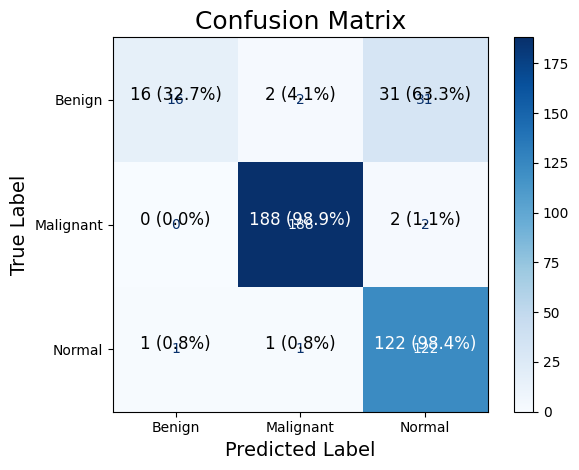

Overall Accuracy: 0.8981


In [29]:
import itertools
plot_confusion_matrix()

In [30]:



# ============================================
# 4. Plot Precision, Recall, and F1 Score
# ============================================
from sklearn.metrics import precision_score, recall_score, f1_score

def plot_classification_metrics():
    """
    Calculate and plot precision, recall, and F1 score for each class.
    """
    # Make predictions on test set
    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true_classes = np.argmax(y_test, axis=1)

    # Calculate metrics for each class
    class_names = ["Benign", "Malignant", "Normal"]

    # Calculate metrics with different averaging methods
    precision = {
        'micro': precision_score(y_true_classes, y_pred_classes, average='micro'),
        'macro': precision_score(y_true_classes, y_pred_classes, average='macro'),
        'weighted': precision_score(y_true_classes, y_pred_classes, average='weighted'),
        'per_class': precision_score(y_true_classes, y_pred_classes, average=None)
    }

    recall = {
        'micro': recall_score(y_true_classes, y_pred_classes, average='micro'),
        'macro': recall_score(y_true_classes, y_pred_classes, average='macro'),
        'weighted': recall_score(y_true_classes, y_pred_classes, average='weighted'),
        'per_class': recall_score(y_true_classes, y_pred_classes, average=None)
    }

    f1 = {
        'micro': f1_score(y_true_classes, y_pred_classes, average='micro'),
        'macro': f1_score(y_true_classes, y_pred_classes, average='macro'),
        'weighted': f1_score(y_true_classes, y_pred_classes, average='weighted'),
        'per_class': f1_score(y_true_classes, y_pred_classes, average=None)
    }

    # Create the plot
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

    # Plot 1: Per-class metrics
    x = np.arange(len(class_names))
    width = 0.25

    bars1 = ax1.bar(x - width, precision['per_class'], width, label='Precision', color='skyblue')
    bars2 = ax1.bar(x, recall['per_class'], width, label='Recall', color='lightgreen')
    bars3 = ax1.bar(x + width, f1['per_class'], width, label='F1 Score', color='salmon')

    # Add labels and title
    ax1.set_xlabel('Class', fontsize=12)
    ax1.set_ylabel('Score', fontsize=12)
    ax1.set_title('Precision, Recall, and F1 Score by Class', fontsize=14)
    ax1.set_xticks(x)
    ax1.set_xticklabels(class_names)
    ax1.legend()
    ax1.grid(alpha=0.3)

    # Add value labels on bars
    def add_labels(bars):
        for bar in bars:
            height = bar.get_height()
            ax1.annotate(f'{height:.2f}',
                        xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom', fontsize=10)

    add_labels(bars1)
    add_labels(bars2)
    add_labels(bars3)

    # Plot 2: Average metrics
    categories = ['Micro Avg', 'Macro Avg', 'Weighted Avg']
    metrics_data = {
        'Precision': [precision['micro'], precision['macro'], precision['weighted']],
        'Recall': [recall['micro'], recall['macro'], recall['weighted']],
        'F1 Score': [f1['micro'], f1['macro'], f1['weighted']]
    }

    # Create grouped bar chart for average metrics
    x = np.arange(len(categories))
    width = 0.25

    avg_bars1 = ax2.bar(x - width, metrics_data['Precision'], width, label='Precision', color='skyblue')
    avg_bars2 = ax2.bar(x, metrics_data['Recall'], width, label='Recall', color='lightgreen')
    avg_bars3 = ax2.bar(x + width, metrics_data['F1 Score'], width, label='F1 Score', color='salmon')

    # Add labels and title
    ax2.set_xlabel('Averaging Method', fontsize=12)
    ax2.set_ylabel('Score', fontsize=12)
    ax2.set_title('Average Precision, Recall, and F1 Score', fontsize=14)
    ax2.set_xticks(x)
    ax2.set_xticklabels(categories)
    ax2.legend()
    ax2.grid(alpha=0.3)

    # Add value labels on bars
    add_labels(avg_bars1)
    add_labels(avg_bars2)
    add_labels(avg_bars3)

    plt.tight_layout()
    plt.show()

    # Print summary
    print("Classification Metrics Summary:")
    print(f"{'Class':<10} {'Precision':<10} {'Recall':<10} {'F1 Score':<10}")
    print("-" * 40)

    for i, class_name in enumerate(class_names):
        print(f"{class_name:<10} {precision['per_class'][i]:.4f}{' '*6} {recall['per_class'][i]:.4f}{' '*6} {f1['per_class'][i]:.4f}")

    print("-" * 40)
    print(f"{'Micro Avg':<10} {precision['micro']:.4f}{' '*6} {recall['micro']:.4f}{' '*6} {f1['micro']:.4f}")
    print(f"{'Macro Avg':<10} {precision['macro']:.4f}{' '*6} {recall['macro']:.4f}{' '*6} {f1['macro']:.4f}")
    print(f"{'Weighted Avg':<10} {precision['weighted']:.4f}{' '*6} {recall['weighted']:.4f}{' '*6} {f1['weighted']:.4f}")



12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step


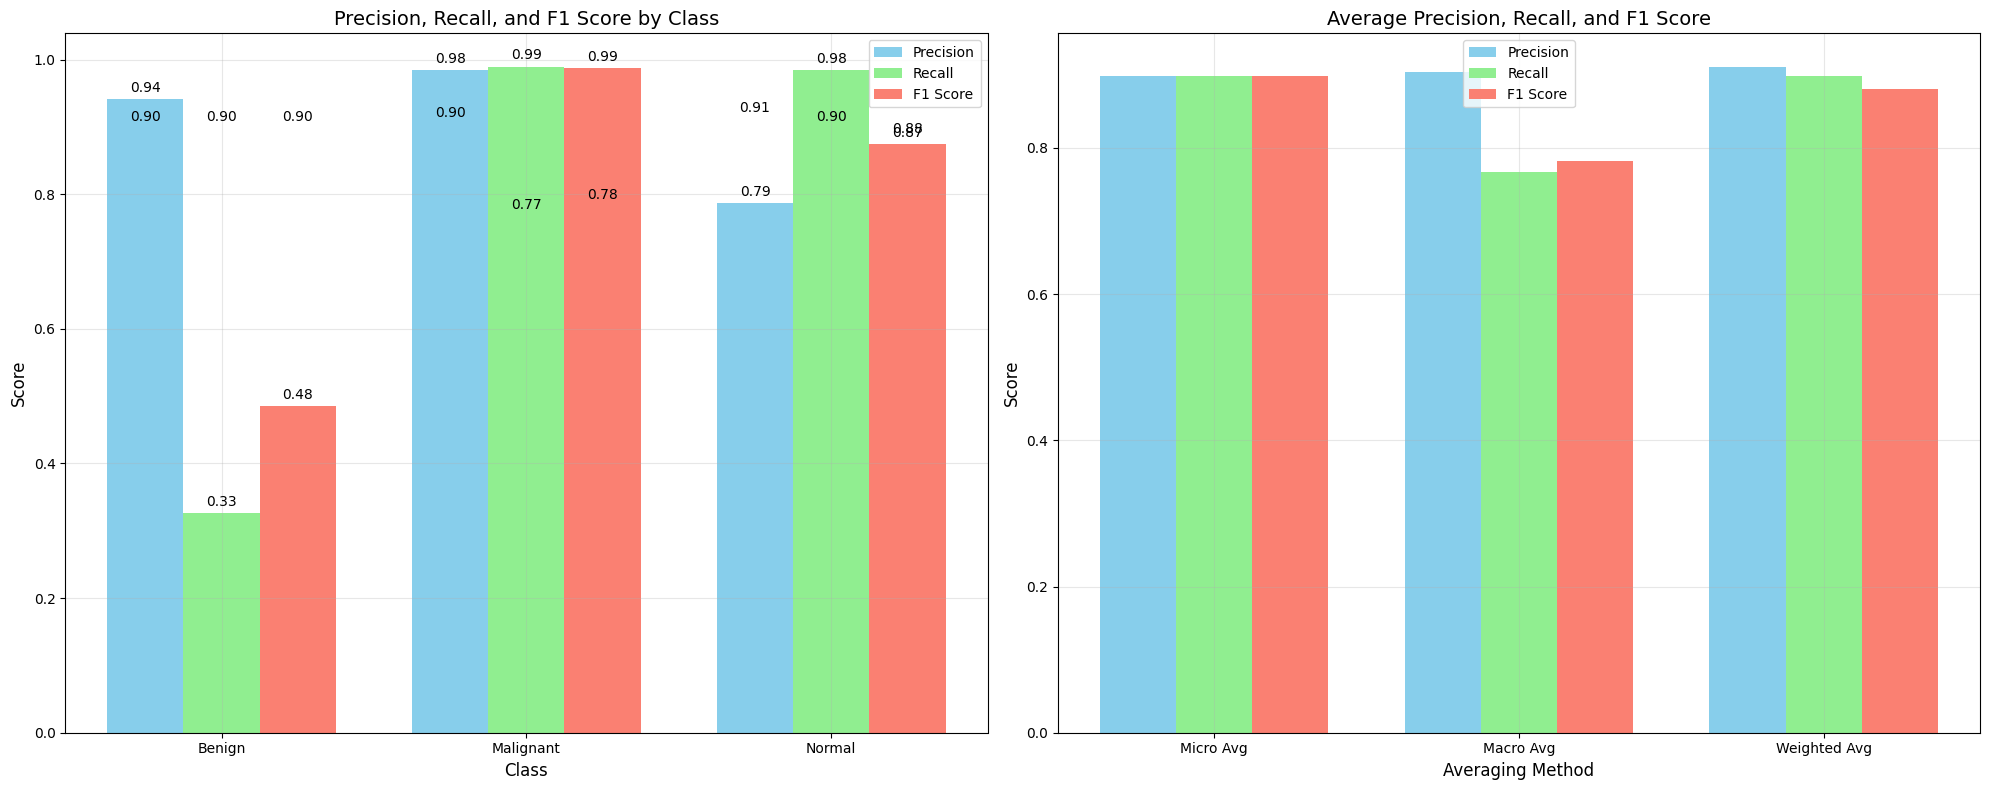

Classification Metrics Summary:
Class      Precision  Recall     F1 Score  
----------------------------------------
Benign     0.9412       0.3265       0.4848
Malignant  0.9843       0.9895       0.9869
Normal     0.7871       0.9839       0.8746
----------------------------------------
Micro Avg  0.8981       0.8981       0.8981
Macro Avg  0.9042       0.7666       0.7821
Weighted Avg 0.9111       0.8981       0.8807


In [31]:
plot_classification_metrics()

In [32]:
# Save the model architecture and weights
model.save('/content/lung_cancer_model.keras')

In [33]:
model.save_weights("/content/lung_cancer_model.weights.h5")